# Tips, Tricks, and Troubleshooting

This notebook highlights some useful things to know when working with PyImageJ.

In [1]:
import imagej
ij = imagej.init('net.imagej:imagej:2.1.0')
ij.getVersion()

'2.1.0/1.53c'

## Automagical conversions
The JPype project performs conversions of data types between Python and Java automatically in many cases. For example:

In [2]:
from scyjava import jimport
ArrayList = jimport('java.util.ArrayList')
women = ['Alyssa', 'Brenda', 'Caroline']
men = ['Dave', 'Edward', 'Fred']
jpeople = ArrayList()
jpeople.addAll(women)
jpeople.addAll(men)
names = ['Throckmorton', 'Alexandra']
names.extend(jpeople)
names

['Throckmorton',
 'Alexandra',
 'Alyssa',
 'Brenda',
 'Caroline',
 'Dave',
 'Edward',
 'Fred']

But in some circumstances you'll need to convert manually:

In [3]:
jpeople

<java object 'java.util.ArrayList'>

In [4]:
str(jpeople)

'[Alyssa, Brenda, Caroline, Dave, Edward, Fred]'

In [5]:
ij.py.from_java(jpeople)

In [6]:
str(ij.py.from_java(jpeople))

"['Alyssa', 'Brenda', 'Caroline', 'Dave', 'Edward', 'Fred']"

In this particular situation, note that Java has a `toString()` method that would help us here to avoid conversion of the entire list. For large lists, this could improve time and space performance.

In [7]:
jpeople.toString()

'[Alyssa, Brenda, Caroline, Dave, Edward, Fred]'

Here's another situation where you currently need a manual conversion. Suppose we have the following sets in Python and Java:

In [8]:
from scyjava import jimport
HashSet = jimport('java.util.HashSet')
moves = set(('jump', 'duck', 'dodge'))
fish = set(('walleye', 'pike', 'trout'))
jbirds = HashSet()
for bird in ('duck', 'goose', 'swan'):
    jbirds.add(bird)

__TRY IT!__

Now we want to know whether the fish and bird sets are disjoint:

In [9]:
#jbirds.isdisjoint(moves)
# TODO: How to fix this problem...?

## Technical note for using ops on numpy arrays

Remember that NumPy arrays become `RandomAccessibleInterval`s and can substitute for `IterableInterval`s using `Views`.

In [10]:
import numpy as np
arr1 = np.array([[1, 2], [3, 4]])
print(type(ij.py.to_java(arr1)))

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


If you need to troubleshoot op workings, look for implementations that use only `IterableInterval`s or `RandomAccessibleInterval`s. To find the implementations use the `print(ij.op().help())` function.

For the multiply function the implementation we used is second to last (`net.imagej.ops.math.IIToRAIOutputII$Multiply`)

In [11]:
# print is required to render new lines
print(ij.op().help('multiply'))

Available operations:
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyDouble(
		ArrayImg arg,
		double value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyFloat(
		ArrayImg arg,
		float value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyLong(
		ArrayImg arg,
		long value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyShort(
		ArrayImg arg,
		short value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedByte(
		ArrayImg arg,
		byte value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedInt(
		ArrayImg arg,
		int value)
	(ArrayImg arg) =
	net.imagej.ops.math.ConstantToArrayImageP$MultiplyUnsignedLong(
		ArrayImg arg,
		long value)
	(Arr

Any ImageJ op that requires a `RandomAccessibleInterval` can run on a numpy array that has been passed to `to_java`.  Remember that this method creates a `view`, meaning that the `Op` is **modifying** the underlying Python object:

Let's run a [Difference of Gaussians](https://en.wikipedia.org/wiki/Difference_of_Gaussians) on our numpy image using ImageJ:

## ij.py convenience methods

These methods can be helpful, especially if you do not know beforehand of which type your image is.

### ij.py.dims
This can be used to determine the dimensions of a numpy **or** ImageJ image:

In [12]:
import numpy as np
# numpy image
img1 = np.zeros([10, 10])
print(img1.shape)
print(ij.py.dims(img1))

(10, 10)
(10, 10)


In [13]:
# imagej image
img2 = ij.py.to_java(img1)
#print(img2.shape) # NB: Won't work.
print(ij.py.dims(img2))

[10, 10]


### ij.py.new_numpy_image

Takes a single image argument, which can either be a numpy image or an imagej image. The new image will have the same shape (dimensions) and dtype (pixel type) as the original.

In [14]:
# create a new numpy image from a numpy image
img3 = ij.py.new_numpy_image(img1)
print(type(img3))

# create a new numpy image from an imagej image
img4 = ij.py.new_numpy_image(img2)
print(type(img4))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


### ij.py.jargs

There are a few methods of ImageJ that want to be given an `Object[]` (array of Java objects). Prominent examples include:
    
* `ij.script().run`
* `ij.op().run`
* `ij.command().run`
* `ij.module().run`

In some cases you may get an error from JPype about ambiguous method overloading if you try passing a Python list. In such a case, try wrapping your `args` list using `ij.py.jargs(args)`.

In [15]:
stuff = ['a', 'b', 'c']
ij.py.to_java(stuff)

<java object 'java.util.ArrayList'>

In [16]:
ij.py.jargs(stuff)

<java array 'java.lang.Object[]'>

## Troubleshooting

### I can't pass my numpy image to an ImageJ op

`ij.py` is really good at converting numpy images into `RandomAccessibleInterval`s. However many ImageJ ops, like `addPoissonNoise`, take other forms of ImageJ images, like `IterableInterval`.

In [17]:
print(ij.op().help('filter.addPoissonNoise'))

Available operations:
	(RealType out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseRealType(
		RealType out,
		RealType in,
		long seed?)
	(IterableInterval out) =
	net.imagej.ops.filter.addPoissonNoise.AddPoissonNoiseMap(
		IterableInterval out,
		IterableInterval in)


We can't call this `Op` on a numpy array since it is a specialized type of `RandomAccessibleInterval`, which does not extend `IterableInterval`.

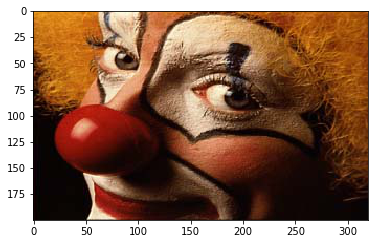

<java class 'net.imglib2.python.ReferenceGuardingRandomAccessibleInterval'>


In [18]:
from skimage import io
img = io.imread('https://imagej.net/images/clown.jpg')

ij.py.show(img)
print(type(ij.py.to_java(img)))

__Try It!__

Try adding noise to this fellow. Uncomment the following line and see what happens!

In [19]:
#ij.op().filter().addPoissonNoise(ij.py.to_java(img))

We can fix this by using `transform.flatIterableView` on both the input and output, which will convert the `ReferenceGuardedRandomAccessibleInterval`s into `IterableInterval`s, allowing us to pass our numpy image into `addPoissonNoise`:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


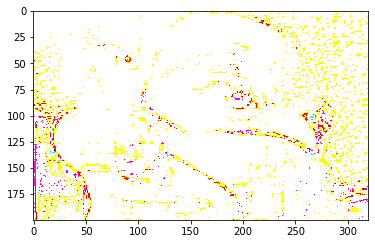

In [20]:
import numpy as np
result = np.zeros(img.shape) # NB: dtype of float32 enables more accurate noise :P

# convert from RandomAccessibleInterval -> IterableInterval
imgIterable = ij.op().transform().flatIterableView(ij.py.to_java(img))
resIterable = ij.op().transform().flatIterableView(ij.py.to_java(result))

ij.op().filter().addPoissonNoise(resIterable, imgIterable)

ij.py.show(result)

In [21]:
result

array([[[220., 156.,  34.],
        [241., 160.,  63.],
        [255., 154.,  52.],
        ...,
        [170.,  88.,  12.],
        [183.,  69.,   0.],
        [148.,  74.,   0.]],

       [[237., 149.,  26.],
        [237., 155.,  47.],
        [232., 163.,  60.],
        ...,
        [186.,  89.,   4.],
        [158.,  86.,  10.],
        [150., 102.,  15.]],

       [[188., 134.,  34.],
        [254., 133.,  29.],
        [227., 176.,  39.],
        ...,
        [193.,  84.,  14.],
        [194.,  93.,  28.],
        [175., 105.,  34.]],

       ...,

       [[ 29.,  13.,  10.],
        [ 16.,   5.,   9.],
        [ 11.,   1.,   1.],
        ...,
        [  8.,   5.,   6.],
        [ 11.,   4.,   2.],
        [  9.,   4.,   4.]],

       [[ 26.,   7.,  11.],
        [ 22.,   5.,   6.],
        [ 16.,   0.,   2.],
        ...,
        [  7.,   4.,   7.],
        [  8.,   2.,   1.],
        [ 12.,   4.,   6.]],

       [[ 31.,  15.,  10.],
        [ 18.,   5.,   6.],
        [ 11.,  

Uh oh!

### Clipping input data to the valid range
This message is given either because (as described in the warning)

* The data consists of floats that are outside the range of [0..1]. This is pretty common and definitely is the case as to why the above data looks so bad.
* The data consists of ints that are outside the range [0..255].

Let's find out which is the culprit by checking some values of `result`:

In [22]:
# grab the RGB values in a line from [0][5] to [0][10] in our image
print(result[0][5:10])

[[265. 181.  38.]
 [224. 157.  45.]
 [252. 147.  39.]
 [266. 165.  31.]
 [218. 146.  41.]]


Thus we not only have floats outside of [0..1] but also values outside of [0..255]; we are faulty of both points in the warning. We can fix this by first [clipping](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.clip.html) the entire array within the integer range, then cast to `uint8` so that the float range no longer applies:

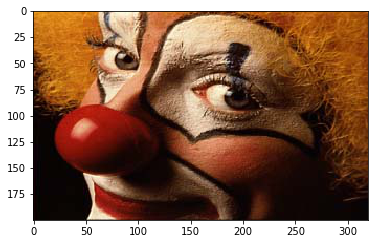

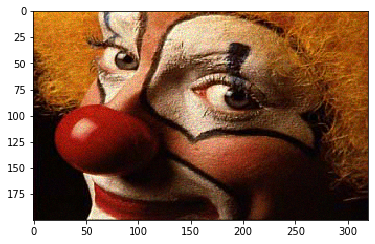

In [23]:
ij.py.show(img.astype(int))
       
result = np.clip(result, 0, 255)
ij.py.show(result.astype(np.uint8))

Now our noisy image displays nicely alongside the original. Note that depending on your data this might not be the right path for you, but using `clip` and `astype` are great tools for rearranging your data within these bounds.